In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import os
import re

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [26]:
SEED = 42
batch_size = 32
token_max_length = 130

In [4]:
df_train = pd.read_csv("/kaggle/input/jigsaw-agile-community-rules/train.csv")
df_test = pd.read_csv("/kaggle/input/jigsaw-agile-community-rules/test.csv")
sample_submission = pd.read_csv("/kaggle/input/jigsaw-agile-community-rules/sample_submission.csv")

print("train size: ", df_train.shape)
print("test size: ", df_test.shape)

train size:  (2029, 9)
test size:  (10, 8)


In [5]:
df_train.head(10)

,row_id,body,rule,subreddit,positive_example_1,positive_example_2,negative_example_1,negative_example_2,rule_violation
0,0,Banks don't want you to know this! Click here ...,"No Advertising: Spam, referral links, unsolici...",Futurology,If you could tell your younger self something ...,hunt for lady for jack off in neighbourhood ht...,Watch Golden Globe Awards 2017 Live Online in ...,"DOUBLE CEE x BANDS EPPS - ""BIRDS""\n\nDOWNLOAD/...",0
1,1,SD Stream [ ENG Link 1] (http://www.sportsstre...,"No Advertising: Spam, referral links, unsolici...",soccerstreams,[I wanna kiss you all over! Stunning!](http://...,LOLGA.COM is One of the First Professional Onl...,#Rapper \n🚨Straight Outta Cross Keys SC 🚨YouTu...,[15 Amazing Hidden Features Of Google Search Y...,0
2,2,Lol. Try appealing the ban and say you won't d...,No legal advice: Do not offer or request legal...,pcmasterrace,Don't break up with him or call the cops. If ...,It'll be dismissed: https://en.wikipedia.org/w...,Where is there a site that still works where y...,Because this statement of his is true. It isn'...,1
3,3,she will come your home open her legs with an...,"No Advertising: Spam, referral links, unsolici...",sex,Selling Tyrande codes for 3€ to paypal. PM. \n...,tight pussy watch for your cock get her at thi...,NSFW(obviously) http://spankbang.com/iy3u/vide...,Good News ::Download WhatsApp 2.16.230 APK for...,1
4,4,code free tyrande --->>> [Imgur](http://i.imgu...,"No Advertising: Spam, referral links, unsolici...",hearthstone,wow!! amazing reminds me of the old days.Well...,seek for lady for sex in around http://p77.pl/...,must be watch movie https://sites.google.com/s...,We're streaming Pokemon Veitnamese Crystal RIG...,1
5,5,I live in the US it's it possible to get in tr...,No legal advice: Do not offer or request legal...,soccerstreams,Public School? You are under no legal obligati...,"OP, you need to get the fuck away from your bo...",It looks like it could be a sterile cotton swa...,That is called battery. Two wrongs don't make...,0
6,6,young kitty watching for your buddy get her he...,"No Advertising: Spam, referral links, unsolici...",sex,Save on Medicine!! Save over $700 a month on ...,Make your life comfortable. Get up to 15% Disc...,They have nothing on the platypus though goo.g...,Try and see if someone at www.siddhantayoga.co...,0
7,7,[liệt dương](http://namkhoathientam.com/nguyen...,"No Advertising: Spam, referral links, unsolici...",gifs,EARN MONEY in online . Just Sign up and View f...,You can use www.easy-lol.com/probuilds/\n\nIt ...,HD | [English Stream](http://www.ufc187livestr...,* **SD - http://livestreamnba.ru/2016/12/19/pr...,0
8,8,"Maybe true, but that's very short-sighted. The...",No legal advice: Do not offer or request legal...,The_Donald,"OP, you need to get the fuck away from your bo...",Steal the dogs back and put a lean on all her ...,Is this 100% legal tho? Are their any copyrigh...,"If you masturbate before the age of 18, you're...",1
9,9,you can sue them for negligence and try and re...,No legal advice: Do not offer or request legal...,legaladvice,"IIRC the laws require photo id, and social sec...",Tell them you want to take possession of the a...,That is called battery. Two wrongs don't make...,"Heard you might have their address, it could b...",1


In [6]:
df_test.head()

,row_id,body,rule,subreddit,positive_example_1,positive_example_2,negative_example_1,negative_example_2
0,2029,NEW RAP GROUP 17. CHECK US OUT https://soundcl...,"No Advertising: Spam, referral links, unsolici...",hiphopheads,"Hey, guys, just wanted to drop in and invite y...",Cum Swallowing Hottie Katrina Kaif Cartoon Xvi...,SD Stream Eng - [Chelsea TV USA](http://soccer...,HD Streams: |[ENG HD Stoke vs Manchester Unite...
1,2030,Make your life comfortable. Get up to 15% Disc...,No legal advice: Do not offer or request legal...,AskReddit,Get a lawyer and get the security camera foota...,That isn't drastic. You tried reaching out to ...,So what are you going to do with the insurance...,It's just for Austria & Germany. If you still ...
2,2031,Kickin' ass and selling underwear!\nJust made ...,"No Advertising: Spam, referral links, unsolici...",gonewild,Good story my friend. Check out my blog at ht...,If you know what exactly you need then you don...,CENTIPEDES\n\nSOME BASED PATRIOTS HAVE CREATED...,[So great! Thanks for sharing.](http://www.che...
3,2032,watch hooters best therein http://clickan...,"No Advertising: Spam, referral links, unsolici...",personalfinance,"Earn 50,000 bonus points with Chase Sapphire P...","Cool, front page! I made this print along with...",[Full HD Movie Online Free](http://www.flickma...,* Karambit Black Pearl\n* 0.02137822 Float (un...
4,2033,bitches for free at this point show all h...,"No Advertising: Spam, referral links, unsolici...",Showerthoughts,code free tyrande --->>> [Imgur](http://i.imgu...,My trade link\nhttps://steamcommunity.com/trad...,**HD** [ mio Stadium 102 HD](http://www.genti....,Infographics is an incredible method for showi...


In [7]:
print('NA in train data:', df_train.isna().values.any())
print('NA in test data:', df_test.isna().values.any())

NA in train data: False
NA in test data: False


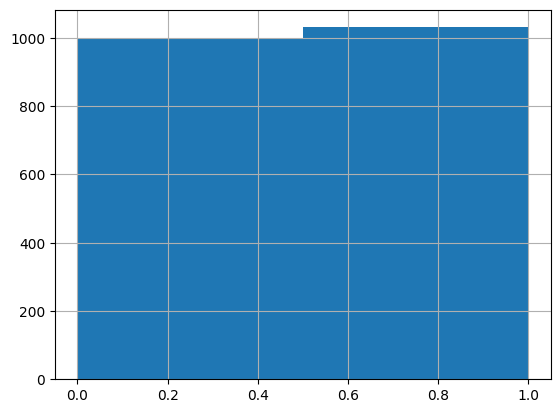

In [8]:
df_train["rule_violation"].hist(bins=2)
plt.show()

# Preparation

In [9]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [10]:
def add_rule_and_subreddit(df):

    new_df = pd.DataFrame()
    new_df["data"] = "Rule: " + df["rule"] + \
              " Subreddit: " + df["subreddit"] + \
              " Comment: " + df['body']
    new_df["label"] = df["rule_violation"]

    return new_df

In [11]:
"""
(Gray Rules): Adding Test data
"""
df_sample = df_test.sample(frac=0.30, random_state=SEED).reset_index(drop=True)

In [12]:
"""
Data Augmentation using examples in train
"""

# positives
pos = df_train[["positive_example_1", "rule", "subreddit"]].rename(
    columns={"positive_example_1": "body"}
)
pos["rule_violation"] = 1

pos_2 = df_train[["positive_example_2", "rule", "subreddit"]].rename(
    columns={"positive_example_2": "body"}
)
pos_2["rule_violation"] = 1

# negatives
neg = df_train[["negative_example_1", "rule", "subreddit"]].rename(
    columns={"negative_example_1": "body"}
)
neg["rule_violation"] = 0

neg_2 = df_train[["negative_example_2", "rule", "subreddit"]].rename(
    columns={"negative_example_2": "body"}
)
neg_2["rule_violation"] = 0

# combine
df_add = pd.concat([pos, pos_2, neg, neg_2], ignore_index=True)

# optional: drop missing texts, ensure int dtype
df_add = df_add.dropna(subset=["body"]).reset_index(drop=True)
df_add["rule_violation"] = df_add["rule_violation"].astype(int)

In [13]:
df_train = pd.concat([df_train, df_add], ignore_index=True)

In [ ]:
df_train.shape

In [14]:
"""
Data Augmentation using examples in test
"""

# positives
pos = df_sample[["positive_example_1", "rule", "subreddit"]].rename(
    columns={"positive_example_1": "body"}
)
pos["rule_violation"] = 1

pos_2 = df_sample[["positive_example_2", "rule", "subreddit"]].rename(
    columns={"positive_example_2": "body"}
)
pos_2["rule_violation"] = 1

# negatives
neg = df_sample[["negative_example_1", "rule", "subreddit"]].rename(
    columns={"negative_example_1": "body"}
)
neg["rule_violation"] = 0

neg_2 = df_sample[["negative_example_2", "rule", "subreddit"]].rename(
    columns={"negative_example_2": "body"}
)
neg_2["rule_violation"] = 0

# combine
df_add = pd.concat([pos, pos_2, neg, neg_2], ignore_index=True)

# optional: drop missing texts, ensure int dtype
df_add = df_add.dropna(subset=["body"]).reset_index(drop=True)
df_add["rule_violation"] = df_add["rule_violation"].astype(int)

In [15]:
df_train_aug = pd.concat([df_train, df_add], ignore_index=True)

In [16]:
df_train_aug = add_rule_and_subreddit(df_train_aug)

In [17]:
print(df_train_aug["data"].loc[9000,])

Rule: No legal advice: Do not offer or request legal advice. Subreddit: conspiracy Comment: Can you beat and rape her? Then get her pregnant and blame her afterwards? I mean it was her fault she was asking for it by being in the same room as me.


# Analysis

In [ ]:
"""
Capital letters count
"""
# def find_capitals(text):
#     matches = re.findall(r"[A-Z!]", text)
#     return len(matches)/len(text)
    
# df_train_aug["capital_ratio"] = df_train_aug["data"].apply(find_capitals)
# sns.histplot(data=df_train_aug, x='capital_ratio', hue='label')

In [ ]:
"""
URLs count
"""
# def find_url(text):
#     # Finds a full URL starting with http or https    
#     matches = re.findall(r"(?:http|https)://[^\s]+", text)

#     if matches:
#         return True
#     else:
#         return False

# df_train_aug['url'] = df_train_aug['data'].apply(find_url)

# # group label and url 
# plot_data = df_train_aug.groupby(['label', 'url']).size().reset_index(name='Count')


# # visuzalize
# sns.set_style("whitegrid")
# plt.figure(figsize=(7, 5))
# palette_dict = {True: 'teal', False: 'darkorange'}

# bar_plot = sns.barplot(
#     data=plot_data,
#     x='label',
#     y='Count',
#     hue='url', 
#     palette=palette_dict
# )

# plt.title('Count of URLs (True/False) per Label Category', fontsize=14)
# plt.xlabel('Label Category', fontsize=12)
# plt.ylabel('Count', fontsize=12)
# plt.legend(title='URL Present', loc='upper right')

# for container in bar_plot.containers:
#     bar_plot.bar_label(container)

# plt.show()

In [ ]:
# print(df_train_aug["label"].loc[3,])
# print(df_train_aug["data"].loc[3,]) # --> http://sh.ors.it/PALI2 (Not really helpful)

# print(df_train_aug["label"].loc[4,])
# print(df_train_aug["data"].loc[4,]) # --> www.paypal.com ("paypal")

In [ ]:
"""
Word Count
"""
# df_train_aug['word_count'] = df_train_aug['data'].map(lambda calc: len(calc))
# sns.histplot(data=df_train_aug, x='word_count', hue='label')

# Text cleaning / Deature Engineering

### Parsing URLs

In [23]:
import urllib.request
from urllib.parse import urlparse

def replace_urls_with_features(text):
    urls = re.findall(r"(?:http|https)://[^\s]+", text)
    for url in urls:
        try:
            parsed = urlparse(url)
            domain = parsed.netloc.lower()
        except ValueError:
            domain = "invalid"

        is_shortener = any(x in domain for x in ["bit.ly", "tinyurl", "t.co"])
        is_social = any(x in domain for x in ["facebook.com", "twitter.com", "instagram.com", "youtube.com"])
        has_ip = bool(re.search(r"\d+\.\d+\.\d+\.\d+", domain))
        num_special_chars = len(re.findall(r"[\?\=\%\@]", url))
        length = len(url)

        # len={length}, specials={num_special_chars},
        
        feature_str = f"<URL:domain={domain}, shortener={is_shortener}, social={is_social}, ip={has_ip}>"
        text = text.replace(url, feature_str)

    return text

In [24]:
df_train_aug["data"] = df_train_aug['data'].apply(replace_urls_with_features)
print(df_train_aug["data"].loc[4,])

Rule: No Advertising: Spam, referral links, unsolicited advertising, and promotional content are not allowed. Subreddit: hearthstone Comment: code free tyrande --->>> [Imgur](<URL:domain=i.imgur.com, shortener=False, social=False, ip=False>

for you and your friend 2 codes for 4 dollars <URL:domain=www.paypal.com, shortener=False, social=False, ip=False>

2$... buy one directly from here: <URL:domain=www.paypal.com, shortener=False, social=False, ip=False>



### Prompt Engineering (URL to Keyword)

In [ ]:
# from transformers import AutoModelForCausalLM, AutoTokenizer

# LLM_MODEL_PATH = "/kaggle/input/qwen2.5/transformers/1.5b-instruct/1"

# model = AutoModelForCausalLM.from_pretrained(
#     LLM_MODEL_PATH,
#     torch_dtype="auto",
#     device_map="auto"
# )
# tokenizer = AutoTokenizer.from_pretrained(LLM_MODEL_PATH)

In [ ]:
# def build_prompt(url):

#     prompt = (
#         f"Please list 3 to 5 keywords that are likely related to the content of this URL: {url}. "
#         f"Answer the keywords only, separated by commas."
#     )
    
#     messages = [
#         {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."},
#         {"role": "user", "content": prompt}
#     ]
    
#     # Qwen-Chat
#     text = tokenizer.apply_chat_template(
#         messages,
#         tokenize=False,
#         add_generation_prompt=True
#     )

#     model_inputs = tokenizer([text], return_tensors="pt").to(model.device)
    
#     generated_ids = model.generate(
#         **model_inputs,
#         max_new_tokens=100,
#         do_sample=True,
#         temperature=0.2,
#         top_p=0.9
#     )
    
#     generated_ids = [
#         output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
#     ]
    
#     response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

#     keywords = re.findall(r"[A-Za-z0-9\-]+", response)
#     return [kw.lower() for kw in keywords if kw.lower() not in ["keywords"]]
    

# def replace_url_to_keywords(text):
#     # Retrieve urls（http/https/www.）
#     urls = re.findall(r'https?://\S+|www\.\S+', text)
#     # print(urls)
#     for url in urls:
#         try:
#             keywords = build_prompt(url)
#             keyword_str = ", ".join(keywords)
#             replacement = f"<URL: {keyword_str}>"
#             text = text.replace(url, replacement)
        
#         except Exception as e:
#             print(f"Error processing {url}: {e}")
#             text = text.replace(url, "<URL: unknown>")
    
#     return text

In [ ]:
# # Test
# url = "https://onlyfans.com/user123"
# print(build_prompt(url))

In [ ]:
# df_train_aug["data"] = df_train_aug["data"].apply(replace_url_to_keywords)

# Model

In [18]:
y = df_train_aug["label"]
X = df_train_aug["data"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [22]:
# Token and Encode Function
def tokenize_and_encode(tokenizer, comments, labels, max_length):
    # Initialize empty lists to store tokenized inputs and attention masks
    input_ids = []
    attention_masks = []

    # Iterate through each comment in the 'comments' list
    for comment in comments:

        # Tokenize and encode the comment using the BERT tokenizer
        encoded_dict = tokenizer.encode_plus(
            comment,

            # Add special tokens like [CLS] and [SEP]
            add_special_tokens=True,

            truncation=True,
            
            # Truncate or pad the comment to 'max_length'
            max_length=max_length,

            # Pad the comment to 'max_length' with zeros if needed
            padding='max_length',

            # Return attention mask to mask padded tokens
            return_attention_mask=True,

            # Return PyTorch tensors
            return_tensors='pt'
        )

        # Append the tokenized input and attention mask to their respective lists
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    # Concatenate the tokenized inputs and attention masks into tensors
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    # Convert the labels to a PyTorch tensor with the data type float32
    labels = torch.tensor(labels, dtype=torch.float32)

    # Return the tokenized inputs, attention masks, and labels as PyTorch tensors
    return input_ids, attention_masks, labels

## Bert-base

In [ ]:
# from transformers import AutoTokenizer, RobertaForSequenceClassification

# tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-base")
# model = RobertaForSequenceClassification.from_pretrained("FacebookAI/roberta-base", num_labels=1)

In [ ]:
# model.save_pretrained("my-roberta-base-cls")
# tokenizer.save_pretrained("my-roberta-base-cls")
# batch_size = 32

In [20]:
MODEL_DIR = "/kaggle/input/my-base-bert/my-bert-cls"

tokenizer = BertTokenizer.from_pretrained(
    MODEL_DIR,
    do_lower_case=True,
    local_files_only=True
)

config = BertConfig.from_pretrained(
    MODEL_DIR,
    local_files_only=True
)

model = BertForSequenceClassification.from_pretrained(
    MODEL_DIR,
    config=config,
    local_files_only=True
)
batch_size = 32

p50: 69 p90: 120 max: 263


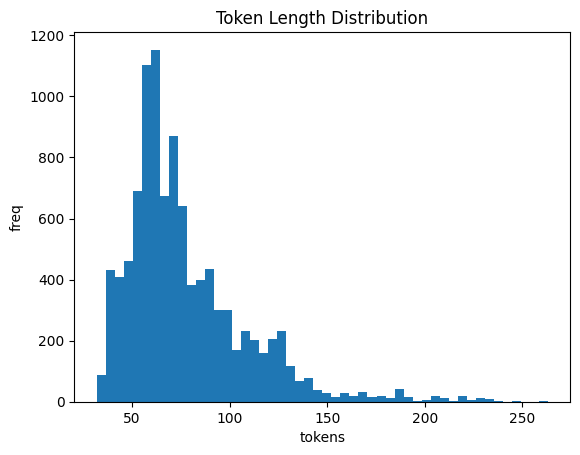

In [21]:
"""
Token length distribution
"""
lengths = [len(tokenizer.encode(t, add_special_tokens=True)) for t in df_train_aug["data"]]
print("p50:", int(np.percentile(lengths, 50)),
      "p90:", int(np.percentile(lengths, 90)),
      "max:", max(lengths))

plt.hist(lengths, bins=50)
plt.title("Token Length Distribution")
plt.xlabel("tokens")
plt.ylabel("freq")
plt.show()

Set the default token to **<b>120</b>**

## Deberta-v3-base

In [ ]:
# from transformers import (
#     AutoTokenizer, AutoConfig, AutoModelForSequenceClassification,
#     DataCollatorWithPadding
# )

# MODEL_DIR = "/kaggle/input/deberta-v3-base/transformers/default/1/deberta-v3-base"

# # Tokenizer
# tokenizer = AutoTokenizer.from_pretrained(
#     MODEL_DIR,
#     use_fast=True,
#     local_files_only=True
# )  

# # Config
# config = AutoConfig.from_pretrained(
#     MODEL_DIR,
#     num_labels=1,
#     problem_type="single_label_classification",
#     local_files_only=True
# )

# # Model
# model = AutoModelForSequenceClassification.from_pretrained(
#     MODEL_DIR,
#     config=config,
#     local_files_only=True
# )

# # For dynamic padding in your DataLoader/Trainer:
# # data_collator = DataCollatorWithPadding(
# #     tokenizer=tokenizer,
# #     pad_to_multiple_of=8  # helpful for fp16, optional
# # )

## Qwen3-0.6B

In [ ]:
# from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification

# QWEN_MODEL_DIR = "/kaggle/input/qwen2.5/transformers/0.5b/1"

# # load the tokenizer and the model
# tokenizer = AutoTokenizer.from_pretrained(
#     QWEN_MODEL_DIR, 
#     padding=True,
#     truncation=True,
#     trust_remote_code=True)
    
# model = AutoModelForSequenceClassification.from_pretrained(
#     QWEN_MODEL_DIR,
#     num_labels=1,
#     trust_remote_code=True
# )


# batch_size = 8

# Prompt Engineering

In [ ]:
# # prepare the model input
# prompt = "Give me a short introduction to large language model."
# messages = [
#     {"role": "user", "content": prompt}
# ]
# text = tokenizer.apply_chat_template(
#     messages,
#     tokenize=False,
#     add_generation_prompt=True,
#     enable_thinking=True # Switches between thinking and non-thinking modes. Default is True.
# )
# model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

# # conduct text completion
# generated_ids = model.generate(
#     **model_inputs,
#     max_new_tokens=32768
# )
# output_ids = generated_ids[0][len(model_inputs.input_ids[0]):].tolist() 

# # parsing thinking content
# try:
#     # rindex finding 151668 (</think>)
#     index = len(output_ids) - output_ids[::-1].index(151668)
# except ValueError:
#     index = 0

# thinking_content = tokenizer.decode(output_ids[:index], skip_special_tokens=True).strip("\n")
# content = tokenizer.decode(output_ids[index:], skip_special_tokens=True).strip("\n")

# print("thinking content:", thinking_content)
# print("content:", content)

# Train

In [ ]:
# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)

In [ ]:
# Tokenize and Encode the comments and labels for the training set
input_ids, attention_masks, labels = tokenize_and_encode(
    tokenizer,
    X_train,
    y_train.values,
    token_max_length,
)

# Tokenize and Encode the comments and labels for the validation set
val_input_ids, val_attention_masks, val_labels = tokenize_and_encode(
    tokenizer,
    X_val,
    y_val.values,
    token_max_length,
)

print('Training Comments :',X_train.shape)
print('Input Ids         :',input_ids.shape)
print('Attention Mask    :',attention_masks.shape)
print('Labels            :',labels.shape)

In [ ]:
# Creating DataLoader for the balanced dataset
train_dataset = TensorDataset(input_ids, attention_masks, labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# validation set 
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
def plot_traing(train_losses, val_losses, train_f1s, val_f1s):

    plt.figure(figsize=(12, 5))

    # Training Loss & Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    # Training Accuracy & Validation F1 Score
    plt.subplot(1, 2, 2)
    plt.plot(train_f1s, label='Train Accuracy')
    plt.plot(val_f1s, label='Val F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Accuracy & F1 Score over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
import copy
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import roc_auc_score

def train_model(model, train_loader, val_loader, device, num_epochs, patience=5):
    # loss_fn = nn.BCELoss()  # binary cross entropy
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # loss_fn = nn.BCEWithLogitsLoss()  
    # optimizer = optim.AdamW(model.parameters(), lr=1e-4)
    
    best_f1 = -1.0
    # best_auc = -1.0
    epochs_no_improve = 0
    best_state = None

    train_losses, val_losses, train_f1s, val_f1s = [], [], [], []
    # train_losses, val_losses, train_aucs, val_aucs = [], [], [], []
    
    for epoch in range(num_epochs):

        model.train()
        total_loss = 0.0
        all_train_preds, all_train_labels = [], []
        # train
        for batch in train_loader:
            
            input_ids, attention_mask, labels = [t.to(device) for t in batch]
            labels = labels.float()

            # prediction (number of batches)
            output = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = output.logits.squeeze(-1)
            probs = torch.sigmoid(logits)  # convert logits to probabilities first
            # print(logits) # DEBUG
                 
            # forward pass
            # loss = loss_fn(probs, labels)
            loss = loss_fn(logits, labels)
            # print(loss) # DEBUG
            
            total_loss += loss.item()

            # backward pass
            optimizer.zero_grad()
            loss.backward()
            
            # update weights
            optimizer.step()

            preds = (probs > 0.5).long()
            all_train_preds.extend(preds.cpu().tolist())
            all_train_labels.extend(labels.cpu().tolist())
            
        train_loss = total_loss / len(train_loader)
        train_f1 = f1_score(all_train_labels, all_train_preds)

        train_losses.append(train_loss)
        train_f1s.append(train_f1)
        
        # Validate
        model.eval()
        val_loss = 0.0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                
                input_ids, attention_mask, labels = [t.to(device) for t in batch]
                labels = labels.float()
                output = model(input_ids=input_ids, attention_mask=attention_mask)
                logits = output.logits.squeeze(-1)
                probs = torch.sigmoid(logits)
                
                # val_loss += loss_fn(probs, labels.float()).item()
                val_loss += loss_fn(logits, labels.float()).item()
                
                preds = (probs > 0.5).long()
                all_preds.extend(preds.cpu().tolist())
                all_labels.extend(labels.cpu().tolist())
                
        val_f1 = f1_score(all_labels, all_preds)
        val_f1s.append(val_f1)
        
        val_losses.append(val_loss)
        val_loss /= len(val_loader)
        
        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_f1:.4f} - "
              f"Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}")

        if val_f1 > best_f1:
            best_f1 = val_f1
            epochs_no_improve = 0
            best_state = copy.deepcopy(model.state_dict())
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping (no val F1 improvement for {patience} epochs). Best Val F1: {best_f1:.4f}")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    # visualize training
    # plot_traing(train_losses, val_losses, train_f1s, val_f1s)
    
    return model

In [ ]:
# Call the function to train the model
model = train_model(model, train_loader, val_loader, device, num_epochs=6, patience=2)

# Inference

In [ ]:
def add_rule_and_subreddit(df):

    new_df = pd.DataFrame()
    
    new_df["data"] = "Rule: " + df["rule"] + \
              " Subreddit: " + df["subreddit"] + \
              " Comment: " + df['body']
    
    new_df["row_id"] = df["row_id"]

    return new_df

In [ ]:
# Align with train data 
df_temp = add_rule_and_subreddit(df_test)
df_temp["data"] = df_temp['data'].apply(replace_urls_with_features)

In [ ]:
def tokenize_test(tokenizer, comments, max_length):
    input_ids, attention_masks = [], []
    for comment in comments:
        enc = tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            truncation=True,
            max_length=max_length,
            padding="max_length",
            return_attention_mask=True,
            return_tensors="pt",
        )
        input_ids.append(enc["input_ids"])
        attention_masks.append(enc["attention_mask"])
    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)

test_input_ids, test_attention_masks = tokenize_test(tokenizer, df_temp["data"], max_length=token_max_length)
test_dataset = TensorDataset(test_input_ids, test_attention_masks)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
def predict(model, loader, device):
    model.eval()
    all_preds = []
    all_probs = []
    
    with torch.no_grad():
        for batch in loader:
            input_ids, attention_mask = [t.to(device) for t in batch]
            
            output = model(input_ids=input_ids, attention_mask=attention_mask)

            logits = output.logits.squeeze(-1)
            probs = torch.sigmoid(logits)
            all_probs.extend(probs.cpu().tolist())
            
    return all_probs

res = predict(model, test_loader, device)

In [ ]:
res

In [ ]:
submission = pd.DataFrame(df_temp["row_id"])
submission["rule_violation"] = res

In [ ]:
submission

In [ ]:
submission.to_csv('submission.csv', index=False)